In [2]:
import numpy as np
import torch
import warnings

warnings.filterwarnings(action='ignore')
torch.manual_seed(59)

### Previous code (Data)

In [3]:
from torchvision import datasets, transforms

data_path = 'data\\cifar\\'
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(
                                               (0.4914, 0.4822, 0.4465),
                                               (0.247, 0.2435, 0.2616)
                                           )
                                       ]))

transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                                           transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize(
                                                   (0.4914, 0.4822, 0.4465),
                                                   (0.247, 0.2435, 0.2616)
                                                   )
                                               ]))

In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in (0, 2)]

cifar2_val = [(img, label_map[label])
              for img, label in transformed_cifar10_val
              if label in (0, 2)]

### Convolutions

In [5]:
from torch import nn

conv = nn.Conv2d(3, 16, kernel_size=3)  # 3 channels, 16 output channels, 3x3 kernel size
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

So the weight is `num_out_channels x num_input_channels x kernel_size x kernel_size`, the bias is unique for every channel, but in channel stays the same

In [6]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [7]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

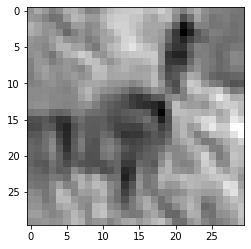

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

With padding

In [9]:
from black import out


conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [10]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)

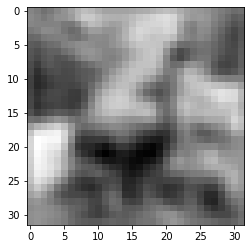

In [11]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

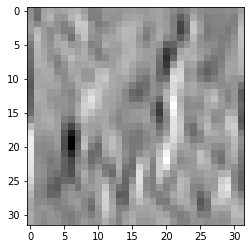

In [12]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

### Pooling (MaxPooling2D)

In [13]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

### Convolutions + Pooling in Birds & Airplanes

In [14]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),   # only recently - flattens the matrix into 1D Vector
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [15]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [16]:
model(img.unsqueeze(0))

tensor([[ 0.0071, -0.1969]], grad_fn=<AddmmBackward0>)

### nn.Module

When we need smth more complex than nn.Sequential.

For example there was no `Flatten` layer earlier, so if we built such a network earlier, we would have to use `nn.Module`.

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        # Reshape instead of `Flatten`, -1 num of batches
        x = x.view(-1, 8 * 8 * 8)
        x = self.act3(self.fc1(x))
        out = self.fc2(x)
        return out

In [18]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### Functional API (more customization)

Keep only layers that are being trained (`nn.Conv2D`, `nn.Linear`). But other layers (activation such as `tanh`, `maxpooling`) we can call from `functional`, as they have no parameters.

In [19]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = F.max_pool2d(F.tanh(self.conv1(x)), 2)  # can also be torch.tanh
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)
        x = x.view(-1, 8 * 8 * 8)
        x = F.tanh(self.fc1(x))
        out = self.fc2(x)
        return out

There is one style matter that will help you avoid surprises with (originally unforeseen) uses: if you need several applications of stateless modules (like `nn.HardTanh` or `nn.ReLU`), it is probably a good idea to have a `separate instance` for each. Reusing the same module appears to be clever and will give correct results with our standard Python usage here, but tools analyzing your model may trip over it.

In [20]:
# Fast check
model = Net()
model(img.unsqueeze(0))

tensor([[0.1113, 0.1225]], grad_fn=<AddmmBackward0>)

### Training

In [21]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

In [22]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [23]:
from torch import nn, optim

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100,
              optimizer=optimizer,
              model=model,
              loss_fn=loss_fn,
              train_loader=train_loader)

2022-07-04 20:56:54.916715 Epoch 1, Training loss 0.5590695879261964
2022-07-04 20:57:27.294240 Epoch 10, Training loss 0.34140109209118374
2022-07-04 20:58:06.881864 Epoch 20, Training loss 0.30192429833351425
2022-07-04 20:58:46.602878 Epoch 30, Training loss 0.2729207852938373
2022-07-04 20:59:27.534889 Epoch 40, Training loss 0.2505986863735375
2022-07-04 21:00:04.607563 Epoch 50, Training loss 0.23015565320754508
2022-07-04 21:00:41.489573 Epoch 60, Training loss 0.21143572938859842
2022-07-04 21:01:15.369164 Epoch 70, Training loss 0.19705463834344203
2022-07-04 21:01:50.864018 Epoch 80, Training loss 0.18259373307228088
2022-07-04 21:02:28.996567 Epoch 90, Training loss 0.16783002538570932
2022-07-04 21:03:06.011861 Epoch 100, Training loss 0.15594404703302747


In [24]:
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        print(f'Accuracy {name}: {correct / total:.2f}')

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


Now we can save the model

In [25]:
data_path = 'data\\chapter_8_model\\'

torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

Load model

In [26]:
data_path = 'data\\chapter_8_model\\'

loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

Check whether GPU is available

In [27]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f'Training on device {device}')

Training on device cpu


### Model design

In [28]:
class NetWidth(nn.Module):
    def __init__(self,  n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, self.n_chans1 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [29]:
model = NetWidth()
sum(p.numel() for p in model.parameters())

38386

Regularization

`L2`

In [30]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

def training_loop_l2reg(n_epochs, optimizer, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)
            ))

However, the SGD optimizer in PyTorch already has a weight_decay parameter that
corresponds to 2 * lambda, and it directly performs weight decay during the update as described previously. It is fully equivalent to adding the L2 norm of weights to the loss, without the need for accumulating terms in the loss and involving autograd. 

`Dropout`

In [31]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

to switch off on evaluating -> `model.eval()` instead of `model.train()`

`Batch Normalization`

In [33]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = self.conv1_batchnorm(self.conv1(x))
        x = F.max_pool2d(torch.tanh(x), 2)
        x = self.conv2_batchnorm(self.conv2(x))
        x = F.max_pool2d(torch.tanh(x), 2)
        x = x.view(-1, 8 * 8 * self.n_chans1 // 2)
        x = torch.tanh(self.fc1(x))
        out = self.fc2(x)
        return out